# **Global Height, Weight, and BMI Data Scraper: Extracting and Organizing International Statistics for Comparative Analysis**

#### **Get Height Data**

In [52]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

In [53]:
# Step 1: Send a GET request to the Wikipedia page
height_url = 'https://en.wikipedia.org/wiki/Average_human_height_by_country'
response = requests.get(height_url)

# Check if the request was successful (status code 200)
if response.status_code != 200:
    print(f"Failed to retrieve the webpage, status code: {response.status_code}")
else:
    # Step 2: Parse the content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Step 3: Find the table with the specific class 'wikitable sortable sort-under-center sticky-header'
    table = soup.find('table', {'class': 'wikitable sortable sort-under-center sticky-header'})

    if table is not None:
        # Step 4: Extract the headers from the table
        headers = []
        for th in table.find_all('th'):
            headers.append(th.get_text(strip=True))

        # Step 5: Extract the rows from the table
        rows = []
        for tr in table.find_all('tr')[1:]:  # Skip the header row
            cols = tr.find_all('td')
            if len(cols) > 0:
                row = [col.get_text(strip=True) for col in cols]
                rows.append(row)

        # Step 6: Create a DataFrame using pandas
        height_df = pd.DataFrame(rows, columns=headers)

        height_df.rename(columns={'Country / region': 'Country'}, inplace=True)

        # Step 7: Display the DataFrame
        print(height_df)
    else:
        print("Table with class 'wikitable sortable sort-under-center sticky-header' not found on the page.")


         Country     Average male height   Average female height  \
0    Afghanistan    168.2 cm (5 ft 6 in)    155.3 cm (5 ft 1 in)   
1        Albania  176.6 cm (5 ft9+1⁄2in)  166.8 cm (5 ft5+1⁄2in)   
2        Albania    174 cm (5 ft8+1⁄2in)  161.8 cm (5 ft3+1⁄2in)   
3        Algeria    169.7 cm (5 ft 7 in)  158.5 cm (5 ft2+1⁄2in)   
4      Argentina  174.5 cm (5 ft8+1⁄2in)    161 cm (5 ft3+1⁄2in)   
..           ...                     ...                     ...   
227   Uzbekistan    169.6 cm (5 ft 7 in)      157 cm (5 ft 2 in)   
228      Vanuatu    167.8 cm (5 ft 6 in)  158.7 cm (5 ft2+1⁄2in)   
229      Vietnam    168.1 cm (5 ft 6 in)  156.2 cm (5 ft1+1⁄2in)   
230       Zambia                       —  158.5 cm (5 ft2+1⁄2in)   
231     Zimbabwe                       —    160.3 cm (5 ft 3 in)   

    Statureratio(male tofemale)  \
0                          1.08   
1                          1.06   
2                          1.08   
3                          1.07   
4       

In [54]:
height_df.head()

,Country,Average male height,Average female height,Statureratio(male tofemale),Sample population / age range,Share ofpop. over 18covered[9][10][b],Method,Year,Ref.
0,Afghanistan,168.2 cm (5 ft 6 in),155.3 cm (5 ft 1 in),1.08,"18–69 (N= m:1,979 f:1,687)",97.2%,Measured,2018,[11]
1,Albania,176.6 cm (5 ft9+1⁄2in),166.8 cm (5 ft5+1⁄2in),1.06,"18–41 (N= m:266(18–41) f:179(18–36), SD= m:7.3...",52.7%,Measured,2020,[12]
2,Albania,174 cm (5 ft8+1⁄2in),161.8 cm (5 ft3+1⁄2in),1.08,"20–29 (N= m:649 f:1,806)",23.5%,Measured,2008–2009,[13][14]
3,Algeria,169.7 cm (5 ft 7 in),158.5 cm (5 ft2+1⁄2in),1.07,"25–64 (N= m:1,626 f:2,491)",68.1%,Measured,2005,[15]
4,Argentina,174.5 cm (5 ft8+1⁄2in),161 cm (5 ft3+1⁄2in),1.08,"Healthy, 18 (N= m:90 f:97, SD= m:7.43 cm (2.9 ...",2.9%,Measured,1998–2001,[16]


In [55]:
# The goal is to handle different year formats (single years, ranges, decades) and prioritize the most recent year,
# while giving preference to "Measured" records over "Self-reported" for duplicate countries.

# Step 1: Function to convert year to a comparable format
def get_year(year):
    # Handle year ranges like '2008–2009'
    if '–' in str(year):
        return int(year.split('–')[1])  # Take the maximum year in the range
    # Handle decade format like '1970s' or '1980s'
    elif 's' in str(year):
        try:
            # Extract the decade and return the last year of the decade (e.g., '1970s' -> 1979)
            return int(str(year)[:4]) + 9
        except ValueError:
            return None  # Handle invalid decade formats
    # Handle single years
    else:
        try:
            return int(year)
        except ValueError:
            return None  # Handle invalid years

# Apply the function to create a 'Comparable Year' column
height_df['Comparable Year'] = height_df['Year'].apply(get_year)

# Step 2: Identify countries with duplicates
duplicate_countries = height_df['Country'].value_counts()[height_df['Country'].value_counts() > 1].index

# Step 3: Apply prioritization only to countries with duplicates
def prioritize_duplicates(df):
    if df['Country'].iloc[0] in duplicate_countries:
        # Sort by 'Comparable Year' (descending), then 'Method' ('Measured' > 'Self-reported')
        df = df.sort_values(by=['Comparable Year', 'Method'], ascending=[False, True])
        # Keep only the first row for each duplicate group (most recent 'Measured' if available)
        return df.head(1)
    else:
        # For countries without duplicates, keep them as is
        return df

# Step 4: Apply the function to each country group
height_df = height_df.groupby('Country').apply(prioritize_duplicates).reset_index(drop=True)

# Display the cleaned DataFrame
height_df

<ipython-input-55-713411df832f>:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  height_df = height_df.groupby('Country').apply(prioritize_duplicates).reset_index(drop=True)


,Country,Average male height,Average female height,Statureratio(male tofemale),Sample population / age range,Share ofpop. over 18covered[9][10][b],Method,Year,Ref.,Comparable Year
0,Afghanistan,168.2 cm (5 ft 6 in),155.3 cm (5 ft 1 in),1.08,"18–69 (N= m:1,979 f:1,687)",97.2%,Measured,2018,[11],2018.0
1,Albania,176.6 cm (5 ft9+1⁄2in),166.8 cm (5 ft5+1⁄2in),1.06,"18–41 (N= m:266(18–41) f:179(18–36), SD= m:7.3...",52.7%,Measured,2020,[12],2020.0
2,Algeria,169.7 cm (5 ft 7 in),158.5 cm (5 ft2+1⁄2in),1.07,"25–64 (N= m:1,626 f:2,491)",68.1%,Measured,2005,[15],2005.0
3,Argentina,174.5 cm (5 ft8+1⁄2in),161 cm (5 ft3+1⁄2in),1.08,"Healthy, 18 (N= m:90 f:97, SD= m:7.43 cm (2.9 ...",2.9%,Measured,1998–2001,[16],2001.0
4,Armenia,171.5 cm (5 ft7+1⁄2in),159.2 cm (5 ft2+1⁄2in),1.08,"18–69 (N= m:605 f:1,449)",90.5%,Measured,2016,[17],2016.0
...,...,...,...,...,...,...,...,...,...,...
179,Uzbekistan,169.6 cm (5 ft 7 in),157 cm (5 ft 2 in),1.08,"18–64 (N= m:1,531 f:2,161)",93.1%,Measured,2014,[215],2014.0
180,Vanuatu,167.8 cm (5 ft 6 in),158.7 cm (5 ft2+1⁄2in),1.06,"25–64 (N= m:2,257 f:2,244)",70.1%,Measured,2011–2012,[216],2012.0
181,Vietnam,168.1 cm (5 ft 6 in),156.2 cm (5 ft1+1⁄2in),1.07,"18 (around 22,400 families across 25 cities an...",—,Measured,2019–2020,[217],2020.0
182,Zambia,—,158.5 cm (5 ft2+1⁄2in),—,"25–49 (N= f:4,091, SD= f:6.5 cm (2.6 in))",54.2%,Self-reported,2007,[32],2007.0


In [56]:
# Clean up columns
# Function to extract height in ft, m, cm from a height string
def extract_height(height_str):
    # Try to extract height in cm directly (e.g., '168.2 cm')
    cm_match = re.search(r'(\d+\.?\d*)\s*cm', height_str)
    if cm_match:
        cm = float(cm_match.group(1))
        ft = cm / 30.48  # Convert cm to feet
        m = cm / 100  # Convert cm to meters
        return pd.Series([round(ft, 2), round(m, 2), cm],
                         index=['Avg height (ft)', 'Avg height (m)', 'Avg height (cm)'])

    # If cm is not found, try extracting feet and inches (e.g., '5 ft 6 in')
    ft_inch_match = re.search(r'(\d+)\s*ft\s*(\d+)\s*in', height_str)
    if ft_inch_match:
        ft = int(ft_inch_match.group(1))
        inches = int(ft_inch_match.group(2))
        cm = ft * 30.48 + inches * 2.54  # Convert feet and inches to cm
        m = cm / 100  # Convert cm to meters
        return pd.Series([round(ft + inches / 12, 2), round(m, 2), round(cm, 2)],
                         index=['Avg height (ft)', 'Avg height (m)', 'Avg height (cm)'])

    # Handle fractional inches like "5 ft 7+1/2 in"
    ft_inch_fraction_match = re.search(r'(\d+)\s*ft\s*(\d+)\s*\+?\s*(\d+)/(\d+)\s*in', height_str)
    if ft_inch_fraction_match:
        ft = int(ft_inch_fraction_match.group(1))
        inches = int(ft_inch_fraction_match.group(2))
        fraction_numerator = int(ft_inch_fraction_match.group(3))
        fraction_denominator = int(ft_inch_fraction_match.group(4))

        # Convert the fractional part to decimal (e.g., 1/2 -> 0.5)
        fractional_inch = fraction_numerator / fraction_denominator
        total_inches = inches + fractional_inch
        cm = ft * 30.48 + total_inches * 2.54  # Convert feet and decimal inches to cm
        m = cm / 100  # Convert cm to meters

        # Return the result, rounding to two decimal places
        return pd.Series([round(ft + total_inches / 12, 2), round(m, 2), round(cm, 2)],
                         index=['Avg height (ft)', 'Avg height (m)', 'Avg height (cm)'])

    # Return None if no match is found
    return pd.Series([None, None, None],
                     index=['Avg height (ft)', 'Avg height (m)', 'Avg height (cm)'])

# Apply the function to the 'Average male height' and 'Average female height' columns
height_df[['Male Avg height (ft)', 'Male Avg height (m)', 'Male Avg height (cm)']] = height_df['Average male height'].apply(extract_height)
height_df[['Female Avg height (ft)', 'Female Avg height (m)', 'Female Avg height (cm)']] = height_df['Average female height'].apply(extract_height)

# Display the updated DataFrame
height_df.head()

,Country,Average male height,Average female height,Statureratio(male tofemale),Sample population / age range,Share ofpop. over 18covered[9][10][b],Method,Year,Ref.,Comparable Year,Male Avg height (ft),Male Avg height (m),Male Avg height (cm),Female Avg height (ft),Female Avg height (m),Female Avg height (cm)
0,Afghanistan,168.2 cm (5 ft 6 in),155.3 cm (5 ft 1 in),1.08,"18–69 (N= m:1,979 f:1,687)",97.2%,Measured,2018,[11],2018.0,5.52,1.68,168.2,5.10,1.55,155.3
1,Albania,176.6 cm (5 ft9+1⁄2in),166.8 cm (5 ft5+1⁄2in),1.06,"18–41 (N= m:266(18–41) f:179(18–36), SD= m:7.3...",52.7%,Measured,2020,[12],2020.0,5.79,1.77,176.6,5.47,1.67,166.8
2,Algeria,169.7 cm (5 ft 7 in),158.5 cm (5 ft2+1⁄2in),1.07,"25–64 (N= m:1,626 f:2,491)",68.1%,Measured,2005,[15],2005.0,5.57,1.70,169.7,5.20,1.58,158.5
3,Argentina,174.5 cm (5 ft8+1⁄2in),161 cm (5 ft3+1⁄2in),1.08,"Healthy, 18 (N= m:90 f:97, SD= m:7.43 cm (2.9 ...",2.9%,Measured,1998–2001,[16],2001.0,5.73,1.75,174.5,5.28,1.61,161.0
4,Armenia,171.5 cm (5 ft7+1⁄2in),159.2 cm (5 ft2+1⁄2in),1.08,"18–69 (N= m:605 f:1,449)",90.5%,Measured,2016,[17],2016.0,5.63,1.72,171.5,5.22,1.59,159.2


In [57]:
filtered_data = merged_df[merged_df['Country'] == 'Qatar']
filtered_data

,Country,Overall BMI,Male BMI,Female BMI,Average male weight,Average female weight,Male Weight (kg),Male Weight (lb),Female Weight (kg),Female Weight (lb),Average male height,Average female height,Male Avg height (ft),Male Avg height (m),Male Avg height (cm),Female Avg height (ft),Female Avg height (m),Female Avg height (cm)
10,Qatar,29.2,29.0,30.1,84.6 kg (186.5 lb),73.4 kg (161.8 lb),84.6,186.51,73.4,161.82,171.2 cm (5 ft7+1⁄2in),157.7 cm (5 ft 2 in),5.62,1.71,171.2,5.17,1.58,157.7


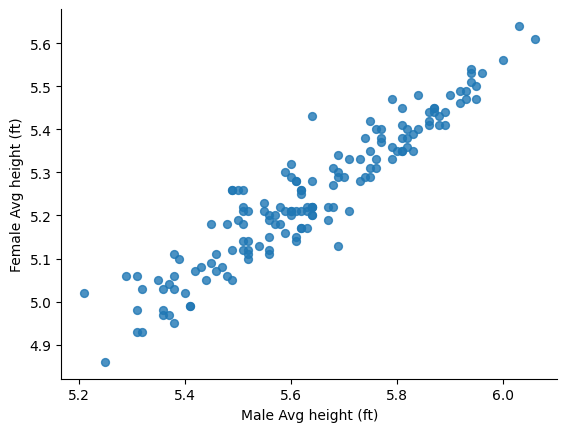

In [58]:
# @title Male Avg height (cm) vs Female Avg height (ft)

from matplotlib import pyplot as plt
height_df.plot(kind='scatter', x='Male Avg height (ft)', y='Female Avg height (ft)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

#### **Get Weight Data**

In [59]:
# Step 1: Send a GET request to the Wikipedia page on Human Body Weight by Country
weight_url = 'https://en.wikipedia.org/wiki/Human_body_weight'
response = requests.get(weight_url)

# Check if the request was successful (status code 200)
if response.status_code != 200:
    print(f"Failed to retrieve the webpage, status code: {response.status_code}")
else:
    # Step 2: Parse the content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Step 3: Find the table with the specific class 'wikitable sortable collapsible collapsed'
    table = soup.find('table', {'class': 'wikitable'})

    if table:
        # Step 4: Extract the headers from the table
        headers = []
        for th in table.find_all('th'):
            headers.append(th.get_text(strip=True))

        # Step 5: Extract the rows from the table
        rows = []
        for tr in table.find_all('tr')[1:]:  # Skip the header row
            cols = tr.find_all('td')
            if len(cols) > 0:
                row = [col.get_text(strip=True) for col in cols]
                rows.append(row)

        # Step 6: Create a DataFrame using pandas
        weight_region_df = pd.DataFrame(rows, columns=headers)

        # Step 7: Display the DataFrame
        print(weight_region_df)
    else:
        print("Table not found on the page.")


                         Region Adultpopulation(millions)      Average weight  \
0                        Africa                       535  60.7 kg (133.8 lb)   
1                          Asia                     2,815  57.7 kg (127.2 lb)   
2                        Europe                       606  70.8 kg (156.1 lb)   
3  Latin AmericaandtheCaribbean                       386  67.9 kg (149.7 lb)   
4                 North America                       263  80.7 kg (177.9 lb)   
5                       Oceania                        24  74.1 kg (163.4 lb)   
6                         World                     4,630  62.0 kg (136.7 lb)   

  %Overweight   Ref  
0       28.9%  [11]  
1       24.2%  [11]  
2       55.6%  [11]  
3       57.9%  [11]  
4       73.9%  [11]  
5       63.3%  [11]  
6       34.7%  [11]  


In [60]:
weight_region_df.head()

,Region,Adultpopulation(millions),Average weight,%Overweight,Ref
0,Africa,535,60.7 kg (133.8 lb),28.9%,[11]
1,Asia,"2,815",57.7 kg (127.2 lb),24.2%,[11]
2,Europe,606,70.8 kg (156.1 lb),55.6%,[11]
3,Latin AmericaandtheCaribbean,386,67.9 kg (149.7 lb),57.9%,[11]
4,North America,263,80.7 kg (177.9 lb),73.9%,[11]


In [61]:
# Step 1: Send a GET request to the Wikipedia page on Human Body Weight by Country
weight_url = 'https://en.wikipedia.org/wiki/Human_body_weight'
response = requests.get(weight_url)

# Check if the request was successful (status code 200)
if response.status_code != 200:
    print(f"Failed to retrieve the webpage, status code: {response.status_code}")
else:
    # Step 2: Parse the content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Step 3: Find the table with the specific class 'wikitable sortable collapsible collapsed'
    table = soup.find('table', {'class': 'wikitable sortable collapsible collapsed'})

    if table:
        # Step 4: Extract the headers from the table
        headers = []
        for th in table.find_all('th'):
            headers.append(th.get_text(strip=True))

        # Step 5: Extract the rows from the table
        rows = []
        for tr in table.find_all('tr')[1:]:  # Skip the header row
            cols = tr.find_all('td')
            if len(cols) > 0:
                row = [col.get_text(strip=True) for col in cols]
                rows.append(row)

        # Step 6: Create a DataFrame using pandas
        weight_global_stats_df = pd.DataFrame(rows, columns=headers)

        # Step 7: Display the DataFrame
        print(weight_global_stats_df)
    else:
        print("Table not found on the page.")


    Rank        Country Kilograms  Pounds Relative size
0      1     Micronesia    87.398  192.68        192.68
1      2          Tonga    87.344  192.56        192.56
2      3  United States    81.928  180.62        180.62
3      4          Samoa    78.544  173.16        173.16
4      5         Kuwait    77.791  171.50         171.5
..   ...            ...       ...     ...           ...
173  174        Vietnam    50.725  111.83        111.83
174  175          Nepal    50.476  111.28        111.28
175  176      Sri Lanka    50.421  111.16        111.16
176  177     Bangladesh    49.591  109.33        109.33
177    —  world average    61.997  136.68        136.68

[178 rows x 5 columns]


In [62]:
weight_global_stats_df.head()

,Rank,Country,Kilograms,Pounds,Relative size
0,1,Micronesia,87.398,192.68,192.68
1,2,Tonga,87.344,192.56,192.56
2,3,United States,81.928,180.62,180.62
3,4,Samoa,78.544,173.16,173.16
4,5,Kuwait,77.791,171.50,171.5


In [63]:
# Step 1: Send a GET request to the Wikipedia page
weight_url = 'https://en.wikipedia.org/wiki/Human_body_weight'
response = requests.get(weight_url)

# Check if the request was successful (status code 200)
if response.status_code != 200:
    print(f"Failed to retrieve the webpage, status code: {response.status_code}")
else:
    # Step 2: Parse the content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Step 3: Find the table with a more flexible approach (e.g., by partial class match)
    table = soup.find('table', {'class': lambda x: x and 'wikitable sortable mw-collapsible' in x and 'sortable' in x})

    if table is not None:
        # Step 4: Extract the headers from the table
        headers = []
        for th in table.find_all('th'):
            headers.append(th.get_text(strip=True))

       # Step 5: Extract the rows from the table
        rows = []
        for tr in table.find_all('tr')[1:]:  # Skip the header row
            cols = tr.find_all('td')
            if len(cols) > 0:
                row = [col.get_text(strip=True) for col in cols]
                rows.append(row)

        # Step 6: Create a DataFrame using pandas
        weight_df = pd.DataFrame(rows, columns=headers)

        # Step 7: Display the DataFrame
        print(weight_df)
    else:
        print("Table not found on the page.")

                   Country  Average male weight Average female weight  \
0              Afghanistan   69.2 kg (152.6 lb)    62.6 kg (138.0 lb)   
1                  Algeria   68.7 kg (151.5 lb)    65.1 kg (143.5 lb)   
2                  Armenia   74.6 kg (164.5 lb)    66.4 kg (146.4 lb)   
3                Australia   87.0 kg (191.8 lb)    71.8 kg (158.3 lb)   
4               Azerbaijan   72.1 kg (159.0 lb)    65.7 kg (144.8 lb)   
5               Bangladesh   55.2 kg (121.7 lb)    49.8 kg (109.8 lb)   
6                  Belarus     69 kg (152.1 lb)      56 kg (123.5 lb)   
7                   Belize   74.2 kg (163.6 lb)    70.5 kg (155.4 lb)   
8                    Benin   63.7 kg (140.4 lb)    60.9 kg (134.3 lb)   
9                   Bhutan   63.2 kg (139.3 lb)    57.4 kg (126.5 lb)   
10                Botswana   63.6 kg (140.2 lb)    64.3 kg (141.8 lb)   
11                  Brazil   72.7 kg (160.3 lb)    62.5 kg (137.8 lb)   
12                  Brunei   74.1 kg (163.4 lb)    

In [64]:
weight_df.head()

,Country,Average male weight,Average female weight,Sample population /age range,Method,Year,Ref
0,Afghanistan,69.2 kg (152.6 lb),62.6 kg (138.0 lb),18–69,Measured,2018,[12]
1,Algeria,68.7 kg (151.5 lb),65.1 kg (143.5 lb),25–64,Measured,2005,[13]
2,Armenia,74.6 kg (164.5 lb),66.4 kg (146.4 lb),18–69,Measured,2016,[14]
3,Australia,87.0 kg (191.8 lb),71.8 kg (158.3 lb),18+,Measured,2018,[15]
4,Azerbaijan,72.1 kg (159.0 lb),65.7 kg (144.8 lb),16+,Measured,2005,[16]


In [65]:
# Clean up columns
# Function to extract weight in kg and lb from a weight string
def extract_weight(weight_str):
    # Try to extract the weight in kg (e.g., '69.2 kg')
    kg_match = re.search(r'(\d+\.?\d*)\s*kg', weight_str)
    if kg_match:
        kg = float(kg_match.group(1))
        lb = kg * 2.20462  # Convert kg to lb
        return pd.Series([round(kg, 2), round(lb, 2)], index=['Weight (kg)', 'Weight (lb)'])

    # If kg is not found, try extracting weight in lb (e.g., '152.6 lb')
    lb_match = re.search(r'(\d+\.?\d*)\s*lb', weight_str)
    if lb_match:
        lb = float(lb_match.group(1))
        kg = lb / 2.20462  # Convert lb to kg
        return pd.Series([round(kg, 2), round(lb, 2)], index=['Weight (kg)', 'Weight (lb)'])

    # Return None if no match is found
    return pd.Series([None, None], index=['Weight (kg)', 'Weight (lb)'])

# Apply the function to the 'Average male weight' and 'Average female weight' columns
weight_df[['Male Weight (kg)', 'Male Weight (lb)']] = weight_df['Average male weight'].apply(extract_weight)
weight_df[['Female Weight (kg)', 'Female Weight (lb)']] = weight_df['Average female weight'].apply(extract_weight)

# Display the updated DataFrame
weight_df.head()


,Country,Average male weight,Average female weight,Sample population /age range,Method,Year,Ref,Male Weight (kg),Male Weight (lb),Female Weight (kg),Female Weight (lb)
0,Afghanistan,69.2 kg (152.6 lb),62.6 kg (138.0 lb),18–69,Measured,2018,[12],69.2,152.56,62.6,138.01
1,Algeria,68.7 kg (151.5 lb),65.1 kg (143.5 lb),25–64,Measured,2005,[13],68.7,151.46,65.1,143.52
2,Armenia,74.6 kg (164.5 lb),66.4 kg (146.4 lb),18–69,Measured,2016,[14],74.6,164.46,66.4,146.39
3,Australia,87.0 kg (191.8 lb),71.8 kg (158.3 lb),18+,Measured,2018,[15],87.0,191.80,71.8,158.29
4,Azerbaijan,72.1 kg (159.0 lb),65.7 kg (144.8 lb),16+,Measured,2005,[16],72.1,158.95,65.7,144.84


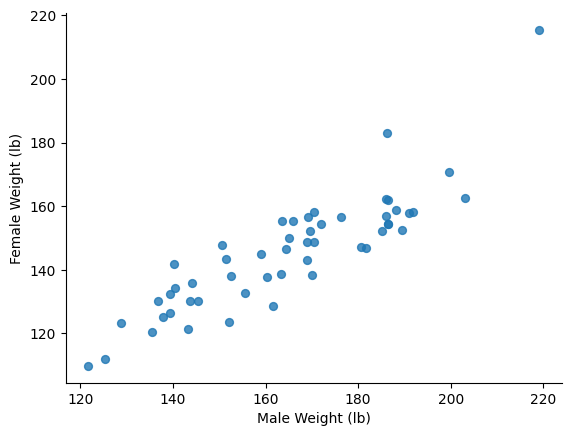

In [66]:
# @title Male Weight (lb) vs Female Weight (kg)

from matplotlib import pyplot as plt
weight_df.plot(kind='scatter', x='Male Weight (lb)', y='Female Weight (lb)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

#### **Get BMI Data**

In [67]:
# Step 1: Send a GET request to the Wikipedia page
bmi_url = 'https://en.wikipedia.org/wiki/List_of_sovereign_states_by_body_mass_index'
response = requests.get(bmi_url)

# Check if the request was successful (status code 200)
if response.status_code != 200:
    print(f"Failed to retrieve the webpage, status code: {response.status_code}")
else:
    # Step 2: Parse the content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Step 3: Find all tables with the class 'wikitable'
    tables = soup.find_all('table', class_='wikitable')

    if tables:
        # Assuming the table you want is the first one; you can adjust if needed.
        table = tables[0]

        # Step 4: Extract the headers from the table
        headers = []
        for th in table.find_all('th'):
            headers.append(th.get_text(strip=True))

        # Step 5: Extract the rows from the table
        rows = []
        for tr in table.find_all('tr')[1:]:  # Skip the header row
            cols = tr.find_all('td')
            if len(cols) > 0:
                row = [col.get_text(strip=True) for col in cols]
                rows.append(row)

        # Step 6: Create a DataFrame using pandas
        bmi_df = pd.DataFrame(rows, columns=headers)

        # Clean up the 'Country' column by removing '*' symbols
        bmi_df['Country'] = bmi_df['Country'].str.replace('*', '', regex=False).str.strip()

        # Step 7: Rename columns to clarify the meaning (Male, Female, and BMI)
        bmi_df.rename(columns={
            'Both': 'Overall BMI',
            'Male': 'Male BMI',
            'Female': 'Female BMI'
        }, inplace=True)

        # Step 8: Display the DataFrame
        print(bmi_df)
    else:
        print("Table not found on the page.")


                   Country Overall BMI Male BMI Female BMI
0                    Nauru        32.5     32.1       32.8
1                    Tonga        31.9     30.4       33.5
2                    Samoa        31.7     29.9       33.5
3                   Kuwait        30.0     29.5       30.8
4    Saint Kitts and Nevis        29.7     28.4       30.9
..                     ...         ...      ...        ...
185             Madagascar        21.1     20.9       21.2
186             Bangladesh        21.0     20.7       21.2
187                Burundi        20.9     20.4       21.3
188               Ethiopia        20.6     20.2       21.0
189                Eritrea        20.5     20.1       21.0

[190 rows x 4 columns]


In [68]:
bmi_df.head()

,Country,Overall BMI,Male BMI,Female BMI
0,Nauru,32.5,32.1,32.8
1,Tonga,31.9,30.4,33.5
2,Samoa,31.7,29.9,33.5
3,Kuwait,30.0,29.5,30.8
4,Saint Kitts and Nevis,29.7,28.4,30.9


### **Clean up**

In [69]:
# Count the number of unique countries in the 'Country' column for each DataFrame
unique_country_bmi = bmi_df['Country'].nunique()
unique_country_weight = weight_df['Country'].nunique()
unique_country_height = height_df['Country'].nunique()

# Print the results
print(f"Number of unique countries in bmi_df: {unique_country_bmi}")
print(f"Number of unique countries in weight_df: {unique_country_weight}")
print(f"Number of unique countries in height_df: {unique_country_height}")

Number of unique countries in bmi_df: 190
Number of unique countries in weight_df: 52
Number of unique countries in height_df: 184


In [70]:
print(height_df.columns.tolist())
print(weight_df.columns.tolist())
print(bmi_df.columns.tolist())

['Country', 'Average male height', 'Average female height', 'Statureratio(male tofemale)', 'Sample population / age range', 'Share ofpop. over 18covered[9][10][b]', 'Method', 'Year', 'Ref.', 'Comparable Year', 'Male Avg height (ft)', 'Male Avg height (m)', 'Male Avg height (cm)', 'Female Avg height (ft)', 'Female Avg height (m)', 'Female Avg height (cm)']
['Country', 'Average male weight', 'Average female weight', 'Sample population /age range', 'Method', 'Year', 'Ref', 'Male Weight (kg)', 'Male Weight (lb)', 'Female Weight (kg)', 'Female Weight (lb)']
['Country', 'Overall BMI', 'Male BMI', 'Female BMI']


In [71]:
import pandas as pd

# Select only the necessary columns from each DataFrame
# Assuming you need 'Country' from each and specific columns like 'Male Weight', 'Female Weight', 'BMI', etc.
weight_columns = ['Country', 'Average male weight', 'Average female weight',
                  'Male Weight (kg)', 'Male Weight (lb)', 'Female Weight (kg)', 'Female Weight (lb)']  # Adjust as needed
bmi_columns = ['Country', 'Overall BMI', 'Male BMI', 'Female BMI']  # Adjust based on available columns in bmi_df
height_columns = ['Country', 'Average male height', 'Average female height',
                  'Male Avg height (ft)', 'Male Avg height (m)', 'Male Avg height (cm)',
                  'Female Avg height (ft)', 'Female Avg height (m)', 'Female Avg height (cm)']  # Adjust as needed

# Select the relevant columns from each DataFrame
bmi_df_selected = bmi_df[bmi_columns]
weight_df_selected = weight_df[weight_columns]
height_df_selected = height_df[height_columns]

# Merge bmi_df and weight_df based on 'Country'
merged_df = pd.merge(bmi_df_selected, weight_df_selected, how='left', on='Country')

# Merge the result with height_df based on 'Country'
merged_df = pd.merge(merged_df, height_df_selected, how='left', on='Country')

# Replace NaN with None (null values for Tableau compatibility)
merged_df = merged_df.where(pd.notnull(merged_df), None)

# Display the final merged DataFrame
merged_df.head()

,Country,Overall BMI,Male BMI,Female BMI,Average male weight,Average female weight,Male Weight (kg),Male Weight (lb),Female Weight (kg),Female Weight (lb),Average male height,Average female height,Male Avg height (ft),Male Avg height (m),Male Avg height (cm),Female Avg height (ft),Female Avg height (m),Female Avg height (cm)
0,Nauru,32.5,32.1,32.8,None,None,NaN,NaN,NaN,NaN,168.1 cm (5 ft 6 in),156.6 cm (5 ft1+1⁄2in),5.52,1.68,168.1,5.14,1.57,156.6
1,Tonga,31.9,30.4,33.5,99.4 kg (219.1 lb),97.7 kg (215.4 lb),99.4,219.14,97.7,215.39,177.9 cm (5 ft 10 in),167 cm (5 ft5+1⁄2in),5.84,1.78,177.9,5.48,1.67,167.0
2,Samoa,31.7,29.9,33.5,None,None,NaN,NaN,NaN,NaN,—,166.6 cm (5 ft5+1⁄2in),NaN,NaN,NaN,5.47,1.67,166.6
3,Kuwait,30.0,29.5,30.8,None,None,NaN,NaN,NaN,NaN,172 cm (5 ft7+1⁄2in),158.6 cm (5 ft2+1⁄2in),5.64,1.72,172.0,5.20,1.59,158.6
4,Saint Kitts and Nevis,29.7,28.4,30.9,84.5 kg (186.3 lb),83.0 kg (183.0 lb),84.5,186.29,83.0,182.98,170.3 cm (5 ft 7 in),161.6 cm (5 ft3+1⁄2in),5.59,1.70,170.3,5.30,1.62,161.6


In [72]:
# Filter rows where 'Country' is 'Australia' and display all columns
filtered_data = merged_df[merged_df['Country'] == 'Qatar']

# Display the rows for Australia
filtered_data

,Country,Overall BMI,Male BMI,Female BMI,Average male weight,Average female weight,Male Weight (kg),Male Weight (lb),Female Weight (kg),Female Weight (lb),Average male height,Average female height,Male Avg height (ft),Male Avg height (m),Male Avg height (cm),Female Avg height (ft),Female Avg height (m),Female Avg height (cm)
10,Qatar,29.2,29.0,30.1,84.6 kg (186.5 lb),73.4 kg (161.8 lb),84.6,186.51,73.4,161.82,171.2 cm (5 ft7+1⁄2in),157.7 cm (5 ft 2 in),5.62,1.71,171.2,5.17,1.58,157.7


In [73]:
# Save the DataFrame to a CSV file
from google.colab import files

# Save the DataFrame to a CSV file
file_path = '/content/merged_data.csv'
merged_df.to_csv(file_path, index=False)

# Trigger the download
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
filtered_data = merged_df[merged_df['Country'] == 'Qatar']
filtered_data

,Country,Overall BMI,Male BMI,Female BMI,Average male weight,Average female weight,Male Weight (kg),Male Weight (lb),Female Weight (kg),Female Weight (lb),Average male height,Average female height,Male Avg height (ft),Male Avg height (m),Male Avg height (cm),Female Avg height (ft),Female Avg height (m),Female Avg height (cm)
10,Qatar,29.2,29.0,30.1,84.6 kg (186.5 lb),73.4 kg (161.8 lb),84.6,186.51,73.4,161.82,171.2 cm (5 ft7+1⁄2in),157.7 cm (5 ft 2 in),5.62,1.71,171.2,5.17,1.58,157.7
